# Bayesian Networks

This TP provides an excellent opportunity to gain further exposure to relevant topics and applications of Bayesian Networks (diagnosis, prediction, etc.).

Objectives: Students will be able to:
- Create Bayesian Networks.
- Learn Bayesian Networks from real-world problems and datasets.
- Determine inferences from Bayesian Networks.

Technology Requirements:
- Linux (windows user may install virtual machines)
- Python 3.8 or higher (due to pgmpy compatibility)
- Download and install pip and then install pgmpy:
   `$ pip install pgmpy`
- If the previous did not work, this can be done manually after downloading the code source:

```
$ git clone https://github.com/pgmpy/pgmpy
$ cd pgmpy/
$ sudo pip install -r requirements.txt
$ sudo python setup.py install
```


*Note: if you encountered problems installing pip or pgmpy, refer to the pgmpy Installation Page: https://pgmpy.org/started/install.html

In [89]:
!pip install pgmpy

In [90]:
import pgmpy
import pgmpy.models
import pgmpy.inference
import pgmpy.estimators
import pgmpy.inference

import networkx as nx
import matplotlib.pyplot
import xgboost

import pandas as pd
import time

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, CausalInference
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, MaximumLikelihoodEstimator
import xgboost as xgb

## Part 0: Building a model from scratch: Monty Hall Problem

You might know about the famous Monty Hall, or three doors problem (https://en.wikipedia.org/wiki/Monty_Hall_problem). This is a TV game where a contestant $Contestant$ interacts with a host $Host$ to find a price $Price$ hidden behind one of three closed doors. The contestant makes a first choice of one door they would like to open. The host will then help the contestant by opening one of the doors, leaving the contestant to choose again amongst 2 doors. If the chosen door hides the price, the constestant wins.

The host rules for choosing a door to open are:
 - never open the door behind which the price is hidden
 - never open the door chosen by the contestant

A mathematician states: "Selecting in the second step the door that wasn't chosen in the first step, has a 66% probability of granting the price to the contestant". We want to use Bayesian Network modeling to affirm or infirm this statement.

We will model this problem with a three states Bayesian Network.
 - $Contestant$ is a random variable with 3 possible values (the first chosen door by the contestant)
 - $Price$ is a random variable with 3 possible values (the price door)
 - $Host$ is a random variable with 3 possible values (the opened door by the host)

The price is placed before the contestant make its first choice, and the contestant has no indication on its location.


**Question**: From your understanding of the statement, write the independence and conditional independence relations you expect about $Contestant, Price, Host$, in the form "X indep Y" or "X indep Y | Z". (*A relation "X indep Y" means that X and Y value are set independently, without any link or interaction. A relation "X indep Y | Z" means that X and Y have been chosen with respect to a same information which is the value of Z, but other than that, there is no further link between the value of X and Y.*)

**Answer:**  
The independencies are as follows :
*Contestant indep Price*  
The conditionnal dependencies are as follows :  
*Host | Price*  
*Host | Contestant*

**TODO 0.1** Instantiate an object you will name `monty_hall`, from the class `pgmpy.models.BayesianNetwork` (https://pgmpy.org/models/bayesiannetwork.html). Add edges with its `.add_edge` method, corresponding to each edge in the Monty Hall graph.

Run the cell after to visualize the network.

In [91]:
# TODO
# Instantiation of a monty hall object from the class pgmpy.models.BayesianNetwork
monty_hall = BayesianNetwork()

# Price influences the choice of Host because the Host doesn't have to open the door where is Price
# Price --> Host
monty_hall.add_edge("Price", "Host")

# Contestant influences the choice of the Host doesn't have to open the door choose by the Contestant
# Contestant --> Host
monty_hall.add_edge("Contestant", "Host")

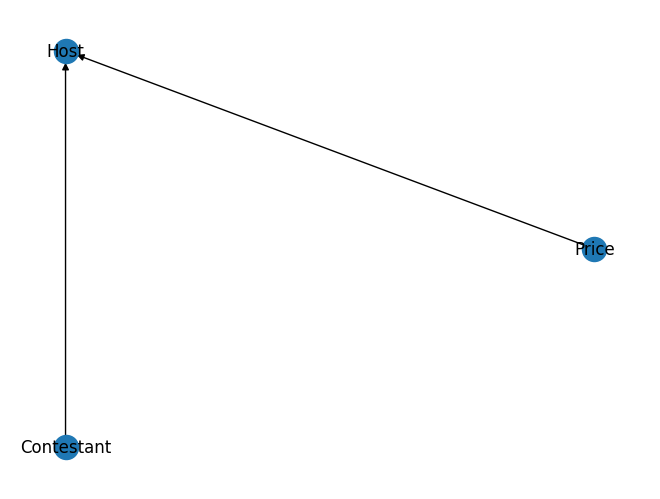

In [92]:
# RUN THIS CELL

def plot_bayesian_network(bn):

    # Convert to a directed graph for visualization
    G = nx.DiGraph(bn.edges())

    # Draw the graph
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

plot_bayesian_network(monty_hall)

**TODO 0.2**: BayesianNetwork objects have a method that allows to find automatically the independence relations: `.get_independencies` (https://pgmpy.org/base/base.html). Verify that the relations encoded in the network match your answer to the first question.

If the relations differ, try to explain your reasoning (no point will be deducted for an explained incorrect answer).

In [93]:
# TODO
# Verification of the independencies

independencies = monty_hall.get_independencies()
print(independencies)

(Contestant ⟂ Price)
(Price ⟂ Contestant)


This result is consistent since the Contestant has no knowledge of the door where the prize is hidden. This result is also consistent with the "edges" defined above.

Since we have specified the structure of the bayesian network in `monty_hall`, we must now provide the conditional probability distribution.

We assume that both $Contestant$ and $Price$ are chosen randomly (with probability uniformly $\frac13$).

**TODO 0.3** Use `pgmpy.factors.discrete.CPD.TabularCPD` (https://pgmpy.org/factors/discrete.html) to specify the conditional probability distribution of $Contestant$ and of $Price$. Name the TabularCPD of "Contestant" as `cpd_c` and "Price" as `cpd_p`.

Hint: a coin toss can be modeled by `TabularCPD("coin_toss", 2, [[0.5], [0.5]])`

The name of each variable (in first argument) must be identical to the corresponding node in the BayesianNetwork graph `montly_hall`.

In [94]:
# TODO
# CPD : Conditional Probability Distribution

# Define cdp for the Contestant
cpd_c = TabularCPD(variable="Contestant", variable_card=3, values=[[1/3], [1/3], [1/3]])

# Define cpd for the Price
cpd_p = TabularCPD(variable="Price", variable_card=3, values=[[1/3], [1/3], [1/3]])

Run the following cell.

In [95]:
# RUN THIS CELL
# This cell define cpd for the Host which depends on the Contestant and the Price


cpd_h = pgmpy.factors.discrete.CPD.TabularCPD("Host",3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],  #Host=0, probability of the Host chooses the first door
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],  #Host=1, probability of the Host chooses the second door
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],  #Host=2, probability of the Host chooses the third door
    ],
    evidence=["Contestant", "Price"],
    evidence_card=[3, 3])

cpd_h._truncate_strtable = lambda x: x  # prevents table truncating
print(cpd_h)

+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Contestant | Contestant(0) | Contestant(0) | Contestant(0) | Contestant(1) | Contestant(1) | Contestant(1) | Contestant(2) | Contestant(2) | Contestant(2) |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Price      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Host(0)    | 0.0           | 0.0           | 0.0           | 0.0           | 0.5           | 1.0           | 0.0           | 1.0           | 0.5           |
+------------+---------------+---------------+

**Question: From the table, what is the value of $\mathbb{P}(Host=0 | Contestant=1, Price=2)$? How do you interpret this value with respect to the problem setting?**

**Answer**:

According to the table, $\mathbb{P}(Host=0 | Contestant=1, Price=2) = 1$.

**Question: How many numerical parameters in total were created to build this Bayesian Network? How many would be needed to create the entire joint probability table of $\mathbb{P}(Contestant, Price, Host)$?**

**Answer:**  
As there is 3 possibility for each variables, the number of define numerical parameters for the bayesian network is 2+2+3²=12
and for the entire probability table this is 3³-1=26.

Run the following cell to add the probability tables to the `monty_hall` object.

In [96]:
# RUN THIS CELL

# We now add the conditional probability distributions (cpd) to the bayesian network.

monty_hall.add_cpds(cpd_c, cpd_p, cpd_h)

# Verify that the model is correctly specified

assert monty_hall.check_model()

If the previous cell throws an error, you may have mispecified either the monty_hall graph (todo 0.1) or the CPD of $Contestant$ and $Price$ (todo 0.3).

You can check how `check_model` verifies the BayesianNetwork in its documentation (https://pgmpy.org/models/bayesiannetwork.html)

### Application

Suppose that you, as a contestant, have chosen $Contestant=0$ as your first guess.

The host might open door $Host=1$, or $Host=2$ as a result (but never door $0$ as it was chosen by the contestant).

**TODO 0.4** Using `pgmpy.inference.ExactInference.VariableElimination` (https://pgmpy.org/exact_infer/ve.html), compute the exact conditional probability distribution of $\mathbb{P}(Price|Contestant=0,Host=1)$ and $\mathbb{P}(Price|Contestant=0,Host=2)$.

Once a VariableElimination object has been set, you can use the class method `VariableElimination.query` with adequate `variables` and `evidence` parameters. The remaining arguments can be set to their default values.

In [97]:
inference = pgmpy.inference.ExactInference.VariableElimination(monty_hall)

# TODO
result_1 = inference.query(variables=["Price"], evidence={"Contestant": 0, "Host":1})
print("P(Price | Contestant=0, Host=1)")
print(result_1)

result_2 = inference.query(variables=["Price"], evidence={"Contestant": 0, "Host":2})
print("\nP(Price | Contestant=0, Host=2):")
print(result_2)

P(Price | Contestant=0, Host=1)
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.0000 |
+----------+--------------+
| Price(2) |       0.6667 |
+----------+--------------+

P(Price | Contestant=0, Host=2):
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.6667 |
+----------+--------------+
| Price(2) |       0.0000 |
+----------+--------------+


**Question**: According to the two result tables, should you maintain your choice of door $Contestant=0$, or select the remaining door?

**Answer**: No we should change our choice because the probability of choosing 2 when host choosed 1 or choosing 1 when host choosed 2 is higher in all case: 0.6667>0.3333

**Question**: Even though the contestant final choice has one of two doors, why are the probability of success not (0.5, 0.5)?

**Answer**: The probabilities are not (0.5,0.5) because the Host's action is not random. It is based on rules that provide indirectly information about the location of the prize. In fact, if the Contestant doesn't chooses the door with the Price, the Host doesn't have the choice he chooses the door without the Price with the probability of 1. This creates an imbalance in favour of the door not chosen by the candidate giving a probability of 2/3 for the Price and 1/3 for the orignial door selected door.

## Part 1: Bayesian Modeling of a credit risk dataset

This part is dedicated to learning a Bayesian model (graph and distribution) to model Credit risk in Germany. In this part, we will not specify the structure by hand, instead it will be learned from the data.

We will see how to:
 - open and inspect a dataset as a DataFrame
 - handle missing values with and without domain knowledge
 - apply binning to variables with lots of possible values with and without domain knowledge
 - separate data into training and validation sets

First, run the following cell to open the data in the form of a `pandas.DataFrame`.

In [98]:
german_credit = pd.read_csv("https://raw.githubusercontent.com/vidhi-chugh/tds_articles/master/pgmpy_WICDS/german_credit.csv")
german_credit

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


**Question**: What do rows represent? What do columns represent?

**Answer**: Each line represents a customer or a separate credit application in Germany. Each column represents the different variables associated for each credit application.

In [99]:
print(german_credit.columns)

Index(['Credit History', 'Age', 'Gender', 'Job', 'Housing', 'Saving accounts',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [100]:
print(german_credit.Risk.unique())

['good' 'bad']



**Question**: What is the name (in the data) of the variable that we want to model?

**Answer**: The name in the data we want to model is the variable called "Risk". This variable can take the value of "good" or "bad" only.

In [101]:
print(german_credit.Purpose.unique())

['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [102]:
print(german_credit.Housing.unique())

['own' 'free' 'rent']


In [103]:
print(german_credit['Saving accounts'].unique())

[nan 'little' 'quite rich' 'rich' 'moderate']


**Question**: Are there categorical variables? Continuous? Discrete?

**Answer**:

Categorical variables are:
- Risk (good or bad)
- Purpose ('radio/TV', 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others')
- Housing ('own', 'free' or 'rent')
- Gender (male or female).
- Saving accounts (nan, 'little', 'quite rich', 'rich', 'moderate')

Continous variables are:
- Age
- Credit amount
- Duration

Discrete variables are:
- Job
- Credit History


### Data Preparation

Before we can use the dataset to model credit risk, we must prepare the data to ensure that it can be used properly. This generally involves three steps.
 - Ensuring that there are no missing values
 - Ensuring that all columns have a type that allows Bayesian Network structure learning and estimation. Specifically, all variables should be discrete, with a sufficiently low number of possible values (https://pgmpy.org/index.html).
 - Separing the data into training and validation sets. The training set is used for structure learning and parameter estimation. The validation set is used to compare different learned models on a prediction task.


We will first handle missing (NaN) values.
- A domain expert tells us that missing values in `"Saving accounts"` are valid. A NaN values show that the credit seeker does not have a saving account. We will replace this value by `"no account"`.

In [104]:
# RUN THIS CELL

# in this cell, german_credit['Saving accounts'].isnull() provides the index table of all null saving account rows.
# then, german_credit.loc[... ,'Saving accounts'] select the cells to be set to the value "no account"

german_credit.loc[german_credit['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

**TODO 1.1**: Is there any other column with missing values? You can use the `DataFrame.isnull()` method to check if a value is null, and the `DataFrame.sum(axis=0)` method to get the number of nonzero values in each column.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html)
(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)

If there is any missing value remaining, remove the corresponding rows from the DataFrame, using the `.dropna()` method.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

In [105]:
# TODO
# Verify is there are missing value
missing_values = german_credit.isnull().sum(axis=0)

if missing_values.any():
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])

    # Delete rows with NaN
    german_credit = german_credit.dropna()
    print("\nRows with deleted missing values:")
else:
    print("There is no missing values in the dataset")

print("\nVerifying missing values after cleaning:")
print(german_credit.isnull().sum(axis=0))

There is no missing values in the dataset

Verifying missing values after cleaning:
Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64


Now that we have dealt with missing values, we must ensure that variables are discrete with low number of possible values.
We will arbitrarily say that **above 10 values** is too many.

When a variable has too many values, we must apply binning to it. Binning means grouping together values under new names, into a small number of categories. There are different strategy to binning.
 - A domain expert might create meaningful binning from prior knowledge. For instance, age is usually grouped in 18-25, 26-45, 46-65, 65+ categories.
 - When no prior knowledge is available, a common strategy on ordered data (where a "lesser than" notion makes sense) is to create bins of equal population with ordered values. For instance, age could be grouped in three groups from 18 to 30, 31 to 37, 37+ if each group correspond to roughly the same number of observations (rows).

The following cell iterates over the columns of the dataset, and for each of them, prints the number of unique values contained in the column. It uses `pd.DataFrame.columns` (https://pandas.pydata.org/docs/reference/frame.html) and `pd.Series.unique` (https://pandas.pydata.org/docs/reference/series.html).

In [106]:
# RUN THIS CELL
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 53 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 921 possible values
Variable 'Duration' has 33 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


**Question** Which columns seem to have too many unique values to handle like categorical variables?

**Answer:** The column of Age, Duration and Credit amount have too many values to do relevant categorical variables. It will be better if we slice the values of this columns in 3 or 5 categories (Ex:young, old... Age: 20-30,30-40,40-50...)

**TODO 1.2**: Apply the function `pandas.qcut` (https://pandas.pydata.org/docs/reference/api/pandas.qcut.html), with quantiles `q=[0, .33, .66, 1]` to make three equally populated bins, for `Age`,`Credit amount`, and `Duration`.

You should replace the previous column with the new value: syntax `dataframe[column] = pd.qcut(...)`.

Age, Credit Amount and Duration have too many unique values to handle like categorical variables so we have to regroup in range of values to get categorical variable. For example with age we regroup in 3 categories young, middle-aged and old.

In [107]:
# TODO
german_credit['Age'] = pd.qcut(german_credit['Age'], q=[0, 0.33, 0.66, 1], labels=['young', 'middle-aged', 'old'])

german_credit['Credit amount'] = pd.qcut(german_credit['Credit amount'], q=[0, 0.33, 0.66, 1], labels=['low', 'medium', 'high'])

german_credit['Duration'] = pd.qcut(german_credit['Duration'], q=[0, 0.33, 0.66, 1], labels=['short', 'medium', 'long'])

print(german_credit.head())

   Credit History    Age  Gender  Job Housing Saving accounts Credit amount  \
0               4    old    male    2     own      no account           low   
1               2  young  female    2     own          little          high   
2               4    old    male    1     own          little        medium   
3               2    old    male    2    free          little          high   
4               3    old    male    2    free          little          high   

  Duration              Purpose  Risk  
0    short             radio/TV  good  
1     long             radio/TV   bad  
2    short            education  good  
3     long  furniture/equipment  good  
4   medium                  car   bad  


In [108]:
# RUN THIS CELL
# verify that Age, Credit amount and Duration have been correctly prepared
for variable in ["Age", "Credit amount", "Duration"]:
    assert len(german_credit[variable].unique())==3
    print("Variable '{}' has the following list of possible values: {}".format(variable, german_credit[variable].unique()))

Variable 'Age' has the following list of possible values: ['old', 'young', 'middle-aged']
Categories (3, object): ['young' < 'middle-aged' < 'old']
Variable 'Credit amount' has the following list of possible values: ['low', 'high', 'medium']
Categories (3, object): ['low' < 'medium' < 'high']
Variable 'Duration' has the following list of possible values: ['short', 'long', 'medium']
Categories (3, object): ['short' < 'medium' < 'long']


The Age, Credit amount and Duration variables have been transformed into ordered categories with 3 values each.

**TODO 1.3**: To separate our Train/Validation sets, use the method `DataFrame.sample` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to sample without replacement a fraction 0.9 of the dataset german_credit, called `train_set`. Use the method `DataFrame.drop` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) with indexes `train_set.index` to create a validation set `val_set`. **IMPORTANT** for reproducibility, make sure to seed your sample selection with parameter `random_state`.

In [109]:
# TODO
train_set = german_credit.sample(frac=0.9, random_state=42)
val_set = german_credit.drop(train_set.index)

We divide the dataset into training set and validation set.

In [110]:
# RUN THIS CELL

assert len(train_set)==900
assert len(val_set)==100

We will put aside the validation set for the remainder of part 1 and part 2.

### Model learning

To learn a Bayesian Network structure fitting the data, `pgmpy` provides several algorithms. We will use Hill Climb Search (https://pgmpy.org/structure_estimator/hill.html).
This algorithm:
 - is greedy: a scoring function is optimized by making gradual modification to a Directed Acyclic Graph, until no modification can improve the score (hence, hill-climbing).
 - is heuristic: the scoring function represents some sort of belief of what a best network structure would be. For instance, a best graph would both fit the data well while having a small *description length* (an encoding of this graph should be as small as possible) (BIC score, AIC score). Another best graph concept would rely on fitting the data well while maximizing a probability over a distribution of graphs (K2 score, DBE score...). See http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf for more details.

**TODO 1.4**: Instanciate `pgmpy.estimators.HillClimbSearch` on the training set. Apply the method `HillClimbSearch.estimate` on the instance, with `k2score`, and otherwise default parameters. Finally, reuse `plot_bayesian_network` defined in part 0 to plot the learned network.


  0%|          | 0/1000000 [00:00<?, ?it/s]

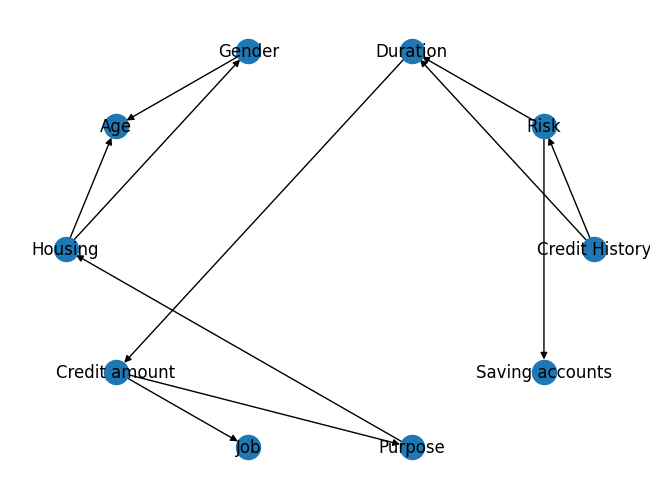

In [111]:
# TODO
# Instanciate HillClimbSearch on training set
hc = HillClimbSearch(train_set)

best_model = hc.estimate(scoring_method=K2Score(train_set))

# Function to plot the learning network
def plot_bayesian_network(bn):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Convert the model into a directed graph for visualisation
    G = nx.DiGraph(bn.edges())

    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))
    plt.show()

plot_bayesian_network(best_model)


In [112]:
for edge in best_model.edges():
    print(f"Learned edge : {edge[0]} --> {edge[1]}")

Learned edge : Credit History --> Risk
Learned edge : Credit History --> Duration
Learned edge : Gender --> Age
Learned edge : Housing --> Age
Learned edge : Housing --> Gender
Learned edge : Credit amount --> Job
Learned edge : Credit amount --> Purpose
Learned edge : Duration --> Credit amount
Learned edge : Purpose --> Housing
Learned edge : Risk --> Duration
Learned edge : Risk --> Saving accounts


We see that Risk is influenced by Saving Accounts, Duration and Credit History. But the direction of the dependances is not good it seems the networks struggling to modelised the direction of dependances.

**TODO 1.5**: The `estimate` method argument `tabu_length` controls how many of the last graph modifications are impossible to modify. Run another graph estimation while setting `tabu_length=1`. Is there any change to the graph?

The tabu_length parameter with the value of 1 introduces a restriction on the number of recent modifications that the algorithm cannot reverse. This helps prevent the algorithm from ‘going back and forth’ between similar configurations, which can help it explore new solutions and escape from local optima.

  0%|          | 0/1000000 [00:00<?, ?it/s]

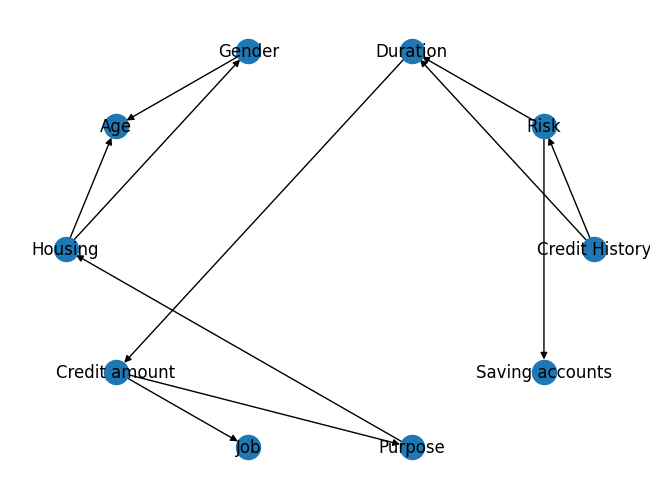

Learned edge : Credit History --> Risk
Learned edge : Credit History --> Duration
Learned edge : Gender --> Age
Learned edge : Housing --> Age
Learned edge : Housing --> Gender
Learned edge : Credit amount --> Job
Learned edge : Credit amount --> Purpose
Learned edge : Duration --> Credit amount
Learned edge : Purpose --> Housing
Learned edge : Risk --> Duration
Learned edge : Risk --> Saving accounts


In [113]:
# TODO
# Learning model with tabu_length=1
best_model_tabu = hc.estimate(scoring_method=K2Score(train_set), tabu_length=1)

plot_bayesian_network(best_model_tabu)

for edge in best_model_tabu.edges():
    print(f"Learned edge : {edge[0]} --> {edge[1]}")

The addition of the restriction "tabu_length=1" has not changed the structure of the graph. It seems the graph is already in a optimum local. We can test others scoring functions like BIC or AIC.

**TODO 1.6**: As mentionned before, different scoring functions encode different beliefs of what an optimal graph would look like. Apply the `estimate` method with `bicscore` scoring method. The BIC (Bayesian Information Criterion) penalizes graphs with a lot of edges, under the belief that the simplest structure is the most likely (Occam's razor https://en.wikipedia.org/wiki/Occam%27s_razor).

  0%|          | 0/1000000 [00:00<?, ?it/s]

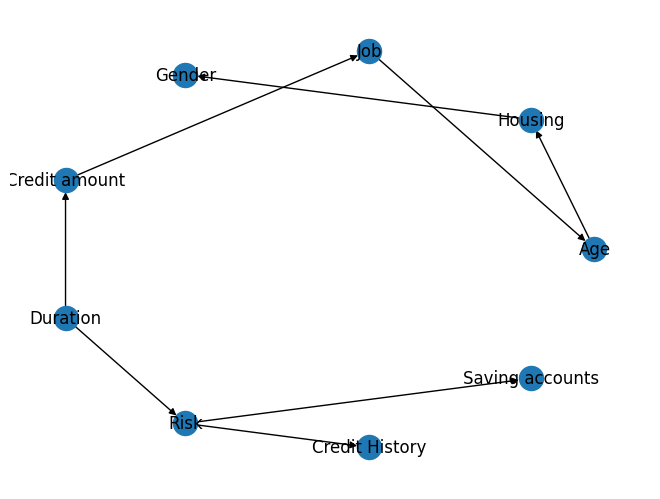

Learned edge : Age --> Housing
Learned edge : Job --> Age
Learned edge : Housing --> Gender
Learned edge : Credit amount --> Job
Learned edge : Duration --> Credit amount
Learned edge : Duration --> Risk
Learned edge : Risk --> Credit History
Learned edge : Risk --> Saving accounts


In [114]:
## TODO
best_model_bic = hc.estimate(scoring_method=BicScore(train_set))

plot_bayesian_network(best_model_bic)

for edge in best_model_bic.edges():
    print(f"Learned edge : {edge[0]} --> {edge[1]}")

**Question: To your opinion, which graph is simpler to interpret?**

**Answer:** The graph with the BIC score is more simple to interpret because he has less edges. This is logical because it concentrates on direct edges and it simplify analysis in reducing interdependeces between the variables.

**Question** To your opinion, which graph is faster to evaluate?

**Answer**: The BIC graph is faster to evaluate due to the reduced number of edges, because the fewer edges there are, the fewer conditional dependencies need to be calculated during inference.

We will now use the graph produced by the `bicscore` method. We now need to learn a set of factor functions to model the joint probability distribution.
Precisely, for each node $V$ with parents (in-going edges) $Pa(V)$, we learn $\mathbb{P}(V|Pa(V))$.

The library pgmpy provides several parameter estimation algorithms, each with different particularities. The one we will use is the following:
 - Maximum Likelihood Estimation (https://pgmpy.org/param_estimator/mle.html): estimates joint probabilities by using the frequency/count of each configuration of values. It needs all variables to be observed in the data.

There are other methods, that do not apply to our case:
 - Expectation Maximization (https://pgmpy.org/param_estimator/em.html): Used in the presence of *latent* variables, i.e. variables in the graph for which there is no data. Expectation Maximization does not maximize the likelihood of the joint distribution, but the expectation of this likelihood.
 - Bayesian Estimation (https://pgmpy.org/param_estimator/bayesian_est.html): Used when domain knowledge, or belief, is known beside what is recorded in the data. This knowledge is specified to the algorithm in the form of *priors*. Due to the additional information, parameter estimates typically require less observations than Maximum Likelihood Estimation.




**TODO 1.7**: Apply MLE (https://pgmpy.org/param_estimator/mle.html) with its `.get_parameters()` method to estimate the parameters of the Bayesian Network. Add the parameters to a model object (class `pgmpy.models.BayesianNetwork`) built from the graph structure obtained with bicscore. You will name this model `model`. Use the training data only.

In [115]:
# TODO
model = BayesianNetwork(best_model_bic.edges())

mle = MaximumLikelihoodEstimator(model, train_set)

model.fit(train_set, estimator=MaximumLikelihoodEstimator)

for cpd in model.get_cpds():
    print(cpd)

+------------------+---------------------+-----+---------------------+---------------------+
| Job              | Job(0)              | ... | Job(2)              | Job(3)              |
+------------------+---------------------+-----+---------------------+---------------------+
| Age(middle-aged) | 0.18181818181818182 | ... | 0.35815602836879434 | 0.4728682170542636  |
+------------------+---------------------+-----+---------------------+---------------------+
| Age(old)         | 0.4090909090909091  | ... | 0.2712765957446808  | 0.3875968992248062  |
+------------------+---------------------+-----+---------------------+---------------------+
| Age(young)       | 0.4090909090909091  | ... | 0.37056737588652483 | 0.13953488372093023 |
+------------------+---------------------+-----+---------------------+---------------------+
+---------------+---------------------+---------------------+---------------------+
| Age           | Age(middle-aged)    | Age(old)            | Age(young)       

Being a homeowner and taking out a short-term loan are associated with lower risks. The people most at risk are those with little or no savings and those applying for long-term loans. These two results seem consistent and make sense. However, some correlations seem counter-intuitive, such as the one between the absence of a savings account and lower risk. This could be because the dataset may not be representative of the population as a whole. For example, if a large number of people in the dataset with no savings account have a good credit history or high income, this could mask a more intuitive correlation between lack of savings and higher risk.

In [116]:
# RUN THIS CELL
assert model.check_model()

This assertion does not generate any errors, so the model respects the necessary properties of a valid Bayesian network, such as the presence of a conditional probability distribution (CPD) for each node, the validity of the CPDs (the probabilities must always be between 0 and 1, and the sum of the probabilities for a given node must be equal to 1), and the absence of cycles in the graph (the graph must be acyclic).

## Part 2: Bayesian Inference

In this part, we will use the previous model to analyse the mechanisms behind Credit Risk attribution by banks.

We will first examine relations between `Gender` and `Risk`.

**TODO 2.1**: Use Variable Elimination to print the joint distribution $\mathbb{P}$(`Gender`,`Risk`). Use Variable Elimination to print the conditional distribution $\mathbb{P}$(`Risk`|`Gender`) for both Gender values.

In [117]:
# TODO
# We apply Variable Elimination Algorithm on the model
inference = VariableElimination(model)

# Calulation of : P(Gender, Risk)
joint_distribution = inference.query(variables=['Gender', 'Risk'])
print("Joint Distribution P(Gender, Risk):")
print(joint_distribution)

# Calculate the conditional distribution : P(Risk | Gender = female)
conditional_female = inference.query(variables=['Risk'], evidence={'Gender': 'female'})
print("\nConditional Distribution P(Risk | Gender = female):")
print(conditional_female)

# Now we calculate the conditional distribution with Gender = male
conditional_male = inference.query(variables=['Risk'], evidence={'Gender': 'male'})
print("\nConditional Distribution P(Risk | Gender = male):")
print(conditional_male)

Joint Distribution P(Gender, Risk):
+----------------+------------+--------------------+
| Gender         | Risk       |   phi(Gender,Risk) |
+================+============+====================+
| Gender(female) | Risk(bad)  |             0.0883 |
+----------------+------------+--------------------+
| Gender(female) | Risk(good) |             0.2117 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(bad)  |             0.2062 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(good) |             0.4938 |
+----------------+------------+--------------------+

Conditional Distribution P(Risk | Gender = female):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2943 |
+------------+-------------+
| Risk(good) |      0.7057 |
+------------+-------------+

Conditional Distribution P(Risk | Gender = male):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+==

The gender difference in risk seems relatively small in the conditional distributions but there is a higher risk for women with this model. However, men have higher probabilities for good and bad risks.

**Question: Are gender differences associated to lowered risk?**

**Answer**: Gender differences are not very marked in terms of risk in the conditional distribution. Women are slightly more at risk, but this does not suggest a strong correlation between gender and reduced risk.

**Quesion: What is hidden in the conditional distribution, that is apparent in the joint distribution?**

**Answer**: Although the conditional risk probabilities do not differ greatly between the genders, the joint distribution shows that men are much more represented in the general population. This means that there are simply more men than women in the dataset, and this is reflected in the joint probabilities.

What prior would be needed to deduce the joint distribution $\mathbb{P}$(`Gender`,`Risk`) from the conditional distributions $\mathbb{P}$(`Risk`|`Gender`)?

**Answer**: According to conditional probabilities we need $\mathbb{P}$(`Gender`) to deduce the joint distribution $\mathbb{P}$(`Gender`,`Risk`) from the conditional distributions $\mathbb{P}$(`Risk`|`Gender`). Because the formula is :

 $\mathbb{P}$(`Risk`|`Gender`) = $\mathbb{P}$(`Gender`,`Risk`) / $\mathbb{P}$(`Gender`)


**TODO 2.2**: Examine how some of the other variables are associated to varying Risk (using conditional distributions). Write down your conclusions.

In [118]:
# TODO

conditional_housing = inference.query(variables=['Risk'], evidence={'Housing': 'own'})
print("\nConditional Distribution P(Risk | Housing = own):")
print(conditional_housing)

conditional_credit_amount = inference.query(variables=['Risk'], evidence={'Credit amount': 'high'})
print("\nConditional Distribution P(Risk | Credit amount = high):")
print(conditional_credit_amount)

conditional_duration = inference.query(variables=['Risk'], evidence={'Duration': 'long'})
print("\nConditional Distribution P(Risk | Duration = long):")
print(conditional_duration)

conditional_saving_accounts = inference.query(variables=['Risk'], evidence={'Saving accounts': 'rich'})
print("\nConditional Distribution P(Risk | Saving accounts = rich):")
print(conditional_saving_accounts)


Conditional Distribution P(Risk | Housing = own):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2946 |
+------------+-------------+
| Risk(good) |      0.7054 |
+------------+-------------+

Conditional Distribution P(Risk | Credit amount = high):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3553 |
+------------+-------------+
| Risk(good) |      0.6447 |
+------------+-------------+

Conditional Distribution P(Risk | Duration = long):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4313 |
+------------+-------------+
| Risk(good) |      0.5687 |
+------------+-------------+

Conditional Distribution P(Risk | Saving accounts = rich):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1429 |
+------------+-------------+
| Risk(good) |      0.85

Owning property is associated with lower risk, so the financial stability of the property plays an important role in risk management (logically). The higher the amount of the loan, the higher the risk, but the risk is still good for more than half of borrowers (64.47%). Having substantial savings is a significant risk-reducing factor. The length of the loan does not really increase the risk.

**BONUS Question Job categories go from "0 - unskilled" to "3 - highly skilled". Does the risk evolution in function of the Job attribute correspond to your expectations? If not, what could be the reason for the difference?**

In [119]:
conditional_job_0 = inference.query(variables=['Risk'], evidence={'Job': 0})
print("\nConditional Distribution P(Risk | Job = 0):")
print(conditional_job_0)

conditional_job_1 = inference.query(variables=['Risk'], evidence={'Job': 1})
print("\nConditional Distribution P(Risk | Job = 1):")
print(conditional_job_1)

conditional_job_2 = inference.query(variables=['Risk'], evidence={'Job': 2})
print("\nConditional Distribution P(Risk | Job = 2):")
print(conditional_job_2)

conditional_job_3 = inference.query(variables=['Risk'], evidence={'Job': 3})
print("\nConditional Distribution P(Risk | Job = 3):")
print(conditional_job_3)


Conditional Distribution P(Risk | Job = 0):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2789 |
+------------+-------------+
| Risk(good) |      0.7211 |
+------------+-------------+

Conditional Distribution P(Risk | Job = 1):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2794 |
+------------+-------------+
| Risk(good) |      0.7206 |
+------------+-------------+

Conditional Distribution P(Risk | Job = 2):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2939 |
+------------+-------------+
| Risk(good) |      0.7061 |
+------------+-------------+

Conditional Distribution P(Risk | Job = 3):
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3211 |
+------------+-------------+
| Risk(good) |      0.6789 |
+------------+-------------+


**Answer**: Against all expectations, the less skilled the job, the lower the good risk. This is counter-intuitive given that these occupations are associated with people in financial difficulty. This may be due to underlying factors such as data bias, complex interactions between variables, or particularities in job classification. For example, a person with a job classification of 3 could invest large sums and therefore run the risk of not being able to repay the loan in the event of a bad investment, like a trader for example.

The Bayesian Network associated to german credit has 9 variables. The previous joint and conditional distribution only involve 2 of them. Therefore, the algorithm has eliminated 7 variables.

The computation time of the inference might change depending on the order in which variables are eliminated. The elimination order is controlled by the parameter `elimination_order` of the `.query` method.

**TODO 2.3** For an identical query of joint probability $\mathbb{P}(Risk, .)$ between the Risk and an arbitrary variable, measure the time spent when given different elimination orders (`greedy`, `MinFill`, `MinNeighbors`, `MinWeight`). You may use `time.time()` to obtain the current time.

In [120]:
# TODO
inference = VariableElimination(model)

elimination_orders = ['greedy', 'MinFill', 'MinNeighbors', 'MinWeight']

variable_to_query = 'Housing'

for order in elimination_orders:
    print(f"\nTesting elimination order: {order}")

    start_time = time.time()
    query_result = inference.query(variables=['Risk', variable_to_query], elimination_order=order)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Time taken with {order} elimination order: {elapsed_time:.4f} seconds")
    print(f"Query result: \n{query_result}")


Testing elimination order: greedy
Time taken with greedy elimination order: 0.0036 seconds
Query result: 
+------------+---------------+---------------------+
| Risk       | Housing       |   phi(Risk,Housing) |
+============+===============+=====================+
| Risk(bad)  | Housing(free) |              0.0328 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(own)  |              0.2095 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(rent) |              0.0522 |
+------------+---------------+---------------------+
| Risk(good) | Housing(free) |              0.0783 |
+------------+---------------+---------------------+
| Risk(good) | Housing(own)  |              0.5016 |
+------------+---------------+---------------------+
| Risk(good) | Housing(rent) |              0.1256 |
+------------+---------------+---------------------+

Testing elimination order: MinFill


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Time taken with MinFill elimination order: 0.1257 seconds
Query result: 
+------------+---------------+---------------------+
| Risk       | Housing       |   phi(Risk,Housing) |
+============+===============+=====================+
| Risk(bad)  | Housing(free) |              0.0328 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(own)  |              0.2095 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(rent) |              0.0522 |
+------------+---------------+---------------------+
| Risk(good) | Housing(free) |              0.0783 |
+------------+---------------+---------------------+
| Risk(good) | Housing(own)  |              0.5016 |
+------------+---------------+---------------------+
| Risk(good) | Housing(rent) |              0.1256 |
+------------+---------------+---------------------+

Testing elimination order: MinNeighbors


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Time taken with MinNeighbors elimination order: 0.2105 seconds
Query result: 
+------------+---------------+---------------------+
| Risk       | Housing       |   phi(Risk,Housing) |
+============+===============+=====================+
| Risk(bad)  | Housing(free) |              0.0328 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(own)  |              0.2095 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(rent) |              0.0522 |
+------------+---------------+---------------------+
| Risk(good) | Housing(free) |              0.0783 |
+------------+---------------+---------------------+
| Risk(good) | Housing(own)  |              0.5016 |
+------------+---------------+---------------------+
| Risk(good) | Housing(rent) |              0.1256 |
+------------+---------------+---------------------+

Testing elimination order: MinWeight


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Time taken with MinWeight elimination order: 0.1423 seconds
Query result: 
+------------+---------------+---------------------+
| Risk       | Housing       |   phi(Risk,Housing) |
+============+===============+=====================+
| Risk(bad)  | Housing(free) |              0.0328 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(own)  |              0.2095 |
+------------+---------------+---------------------+
| Risk(bad)  | Housing(rent) |              0.0522 |
+------------+---------------+---------------------+
| Risk(good) | Housing(free) |              0.0783 |
+------------+---------------+---------------------+
| Risk(good) | Housing(own)  |              0.5016 |
+------------+---------------+---------------------+
| Risk(good) | Housing(rent) |              0.1256 |
+------------+---------------+---------------------+


The calculation time varies greatly depending on the order of elimination used. For this specific query, the greedy order is the fastest, while the more optimised orders such as MinFill, MinWeight, and MinNeighbors are a little slower but aim to preserve the structure of the graph. If you want to optimise execution time fro frequent queries, the greedy ordre may be a good choice. However, for more complex graphs where structure is crucial, orders such as MinFill are often more appropriate

The Bayesian Network can help us with *Feature Selection*. The goal of feature selection is to select a subset of variables that contain all the necessary information about `Risk`, i.e., the *Markov Blanket*.

For instance, variable `Job` might have information on `Risk` (i.e., not independent), but this information might already be contained in another variable, making `Job` redundant.

**TODO 2.4** To know which variables can be made independent from `Risk` by conditioning on other variables, it is possible to use the graph structure. Find a Markov Blanket of `Risk`. The method `BayesianNetwork.get_markov_blanket` (https://pgmpy.org/base/base.html) is ready made for this task.

In [121]:
## TODO
markov_blanket = model.get_markov_blanket('Risk')
print(markov_blanket)

['Duration', 'Saving accounts', 'Credit History']


This result means that all the information needed to determine Risk is contained in these four variables, so once we know the values of Credit History, Housing, Saving accounts and Duration, the Risk variable is independent of all the other variables in the model, such as Job or Gender.

**Question** Interpret the markov blanket information: what is a markov blanket and what does it mean regarding how banks attribute credit risk rating?

**Answer**: A Markov Blanket of a variable in a Bayesian network is the minimal set of variables which, once they are known, make this variable independent of all the other variables in the model. Risk's Markov Blanket contains Risk's parents, Risk's children and the parents of Risk's children. The result above means that all the information needed to determine Risk is contained in these four variables, so once we know the values of Credit History, Housing, Saving accounts and Duration, the Risk variable is independent of all the other variables in the model, such as Job or Gender.

#### BONUS: causal inference

**This bonus part covers an application of Bayesian Network not covered during the CM. You may go to part 3 directly then come back to it later.**

We will now consider the variable `Job`, for which we observe that Risk is different depending on the category. We can say clearly that Job and Risk aren't **independent**. What we cannot say while looking uniquely at the conditional probability distribution, is whether `Job` influences (is a cause of) `Risk`. Indeed, variables can be associated but not causated.

It is generally difficult to determine causal relationships from observed data. Assuming that causal effects are *linear* (meaning that if `Job` has an influence on `Risk`, then this influence can be correctly modeled by a linear regression model), the causal inference framework (https://pgmpy.org/exact_infer/causal.html) allows to estimate whether two associated variables have a causal influence on each other (Average Treatement Effect https://en.wikipedia.org/wiki/Average_treatment_effect). The question it solves is the following: "if a credit seeker's job category were to increase due to a job change, how much would Risk increase?"

Precisely, the ATE is the difference between the expected Risk when the job stays the same, compared to the expected Risk when the job category increases.

**TODO 2.6**: Apply `pgmpy.inference.CausalInference` with its method `.estimate_ate` on training data, to infer if `Job` has an influence on `Risk`.

In [122]:
#TODO
causal_inference = CausalInference(model)

ate_result = causal_inference.estimate_ate(
    X='Job',
    Y='Risk',
    treatment='Job',
    outcome='Risk',
    data=train_set,
    treatment_values=[1, 2]
)

print(f"Estimated Average Treatment Effect of Job on Risk: {ate_result}")

Estimated Average Treatment Effect of Job on Risk: 0.0


**Question**: Is Job category causaly linked to Risk?

**Answer**: The result is 0, so according to the causal analysis performed by the Bayesian model, the change in job category has no direct causal effect on credi risk. This is consistent with the conditional probabilities calculated above. In fact, the value of job=0, 1, 2 or 3 very much affected the conditional probabilities

We now consider the variable `Duration`. We can confirm that it is associated to `Risk`, with higher credit amount related to greater proportion of 'bad' risk. Again, we would like to know if this is a cause-effect relation.

We will now use another way of quantifying causal relationships: *do-calculus* with *counterfactuals*. The question it solves is: "if all credit seekers were to be attributed the same duration by the bank, how would risk be distributed?" If Duration and Risk are not causaly linked, then the resulting distribution of Risk will be identical for all durations.

**TODO 2.7**: Use `CausalInference.query` to estimate the Risk after a do operation on Duration for each category of duration (specify `do={"Duration":value}` for appropriate values).


In [123]:
#TODO
duration_values = ['short', 'medium', 'long']

for value in duration_values:
    do_query_result = causal_inference.query(variables=['Risk'], do={'Duration': value})
    print(do_query_result)

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2081 |
+------------+-------------+
| Risk(good) |      0.7919 |
+------------+-------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2916 |
+------------+-------------+
| Risk(good) |      0.7084 |
+------------+-------------+
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4313 |
+------------+-------------+
| Risk(good) |      0.5687 |
+------------+-------------+


**Question**: Is Duration causaly linked to Risk?

**Answer**: The results show a causal relationship between credit duration and credit risk. The longer the duration of the loan, the greater the probability of high risk (bad). This seems logical, since interest costs more if a loan is spread over 10 years than over 20 years.

## Part 3: Bayesian models as predictive models

Now that we have learned a model of the training data, we can apply it to validation data to evaluate how it works as a predictive model. We can use Maximum A Posteriori inference, to find out what Risk is most likely considering the values of the other variables. Formally, for a given validation sample $s$ where Risk is removed, we want to estimate $\arg \max \mathbb{P}(Risk | Gender,...,Housing=s)$.

**TODO 3.1**: Use `VariableElimination.map_query` (https://pgmpy.org/exact_infer/ve.html) to predict and store credit risk for each sample in the validation set. You can iterate over samples by using `val_set.to_dict()`, each row being converted to a dictionary. Make sure to not include `Risk` in the evidences.

You will need to store the true risk in a list `y_true` for each sample, and store the corresponding predicted value into a list `y_pred`.

In [124]:
#TODO

inference = VariableElimination(model)

y_true = []
y_pred = []

# To have all variables present in the bayesian model
model_variables = model.nodes()

for _, sample in val_set.iterrows():

    sample_dict = sample.to_dict()

    true_risk = sample_dict.pop('Risk')
    # Keep only variables present in the bayesian model
    sample_dict = {var: sample_dict[var]for var in sample_dict if var in model_variables}


    y_true.append(true_risk)

    predicted_risk = inference.map_query(variables=['Risk'], evidence=sample_dict)

    y_pred.append(predicted_risk['Risk'])

print("True Risk values:", y_true)
print("Predicted Risk values:", y_pred)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

True Risk values: ['bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'bad', 'bad', 'good', 'good', 'bad', 'bad', 'good', 'bad', 'bad', 'good', 'bad', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good']
Predicted Risk values: ['bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'goo

This code uses a Bayesian model to predict the credit risk for each sample in the validation set by performing Maximum A Posteriori (MAP) inference.

Run the next cell to visualize the classification performance.

Classification accuracy: 0.71


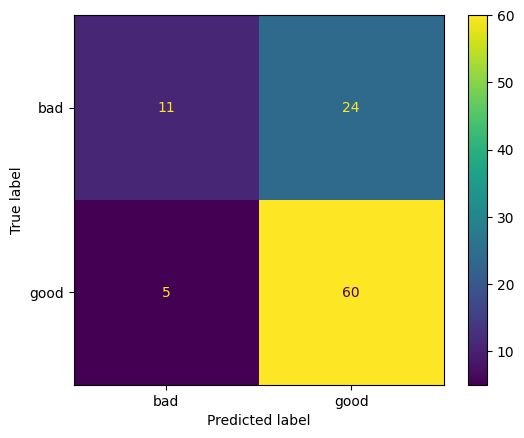

In [125]:
# RUN THIS CELL

print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question** The previous snipet plots a Confusion Matrix. Briefly explain what it means.

**Answer**: The confusion matrix is a table used to evaluate the performance of a classification model. It compares the model's predictions with the actual values for a set of data providing a count of correctly and incorrectly classified results. Here 11 samples have been correctly classify like bad we call them true positives TP, 60 samples have been correctly classify like good we call them True negative TN. But 5 samples was good and they have been classify like bad (False positive FP) and 24 samples was bad and they have been classify like good (False negative FN).

**Question** What is the link between the confusion matrix and the accuracy metric?

We compute accuracy with the following formula:

Accuracy = (TP + TN)/(TP + TN + FP + FN)
Accuracy = (60 +11) / (60+11+5+24)
Accuracy = 0.71

Accuracy is relatively good, but the model shows weaknesses in correctly detecting bad cases.



**Question** What would be False Positive and False Negative in this confusion matrix? Which one would you rather minimize if you were to work for a bank?

**Answer**: It is more important to minimise False Negatives (FN). In fact, a false negative means incorrectly classifying a high-risk applicant as low-risk, which could leave people borrowing when they are very likely to be unable to repay and that is very dangerous for a bank.

We would like to compare the previous map_query predictive model to a standard machine learning model.

We will use XGBoost, one of the main libraries of simple learning models based on "boosting" and specifically "gradient boosting" (https://xgboost.readthedocs.io/en/stable/).


XGBoost is a library that can only manipulate numerical values. Columns "Gender", "Housing", "Saving accounts", "Purpose", and "Risk" contain strings, so we need to transform them. For each of these columns, the next cell creates a new column with suffix "_numerical" (i.e. "Gender_numerical"), where each of the string values is replaced by an integer. This can be done with `.apply`
(https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) and a function, or `.map` (https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) and a dictionary.


In [126]:
# Run this cell.

#method 1
label_mapping = {'good': 0, 'bad': 1}
val_set['Risk_numerical'] = val_set['Risk'].map(label_mapping)
train_set['Risk_numerical'] = train_set['Risk'].map(label_mapping)

#method 2
label_mapping = dict([(value,index) for index,value in enumerate(german_credit["Gender"].unique())])
val_set['Gender_numerical'] = val_set['Gender'].map(label_mapping)
train_set['Gender_numerical'] = train_set['Gender'].map(label_mapping)

#method 3
label_mapping = lambda x: german_credit["Housing"].unique().tolist().index(x)
val_set['Housing_numerical'] = val_set['Housing'].apply(label_mapping)
train_set['Housing_numerical'] = train_set['Housing'].apply(label_mapping)

label_mapping = lambda x: german_credit["Saving accounts"].unique().tolist().index(x)
val_set['Saving accounts_numerical'] = val_set['Saving accounts'].apply(label_mapping)
train_set['Saving accounts_numerical'] = train_set['Saving accounts'].apply(label_mapping)

label_mapping = lambda x: german_credit["Purpose"].unique().tolist().index(x)
val_set['Purpose_numerical'] = val_set['Purpose'].apply(label_mapping)
train_set['Purpose_numerical'] = train_set['Purpose'].apply(label_mapping)

Run the next cell. Its purpose is to make XGBoost and Pandas aware of the categorical nature of some columns.

In [127]:
##  Run this cell.
# Make sure that the column names correspond.

train_set['Purpose_numerical'] = train_set['Purpose_numerical'].astype("category")
val_set['Purpose_numerical'] = val_set['Purpose_numerical'].astype("category")
train_set['Saving accounts_numerical'] = train_set['Saving accounts_numerical'].astype("category")
val_set['Saving accounts_numerical'] = val_set['Saving accounts_numerical'].astype("category")
train_set['Housing_numerical'] = train_set['Housing_numerical'].astype("category")
val_set['Housing_numerical'] = val_set['Housing_numerical'].astype("category")
train_set['Gender_numerical'] = train_set['Gender_numerical'].astype("category")
val_set['Gender_numerical'] = val_set['Gender_numerical'].astype("category")
train_set['Risk_numerical'] = train_set['Risk_numerical'].astype("category")
val_set['Risk_numerical'] = val_set['Risk_numerical'].astype("category")
train_set['Duration'] = train_set['Duration'].astype("category")
val_set['Duration'] = val_set['Duration'].astype("category")
train_set['Age'] = train_set['Age'].astype("category")
val_set['Age'] = val_set['Age'].astype("category")
train_set['Credit amount'] = train_set['Credit amount'].astype("category")
val_set['Credit amount'] = val_set['Credit amount'].astype("category")

**TODO 3.2** In the next cell, create an XGBClassifier model (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) with adequate parameter values. Train (`.fit`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.fit) on `train_set` with the columns `full_variables` to predict "Risk_numerical". Predict (`.predict`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.predict) on the validation set `val_set`, and store the result as `y_pred`.

Hint: for categorical values to be handled, a parameter "enable_categorical" must be set to true at model declaration.

In [128]:
full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]

# Creating the XGBClassifier model with the parameters enable_categorical enabled
model_xgb = xgb.XGBClassifier(
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
# Training
model_xgb.fit(train_set[full_variables], train_set['Risk_numerical'])

# Preidction
y_pred = model_xgb.predict(val_set[full_variables])

print("Predicted Risk values:", y_pred)
print("Classification accuracy:", accuracy_score(val_set['Risk_numerical'], y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:55:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicted Risk values: [1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Classification accuracy: 0.71


Run the next cell to evaluate the performance of the model.

Classification accuracy: 0.71


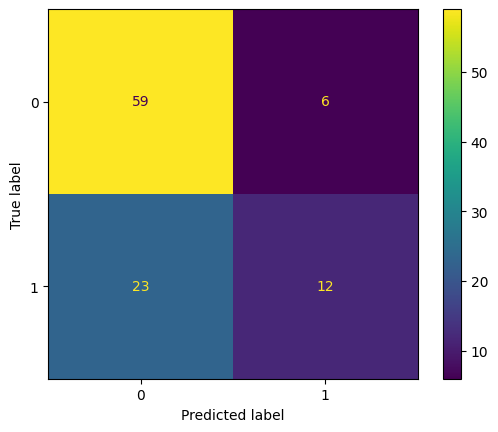

In [129]:
y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

The accuracy is identical to that of the bayesian model. The XGBoost model has better control of false positives. However, it has a higher number of false negatives (23 compared with 24 for the Bayesian model), so XGBoost also has difficulty in correctly identifying the bad.

**TODO 3.3** Train and evaluate another XGBClassifier, this time with input data restricted to the markov blanket found in TODO 2.4.

In [135]:
markov_blanket_variables = [
    "Credit History", "Housing_numerical", "Saving accounts_numerical", "Duration"
]

#XGBClassifier model
model_xgb_markov = xgb.XGBClassifier(
    enable_categorical=True,
    use_label_encoder='logloss',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_xgb_markov.fit(train_set[markov_blanket_variables], train_set['Risk_numerical'])

y_pred_markov = model_xgb_markov.predict(val_set[markov_blanket_variables])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification accuracy: 0.71


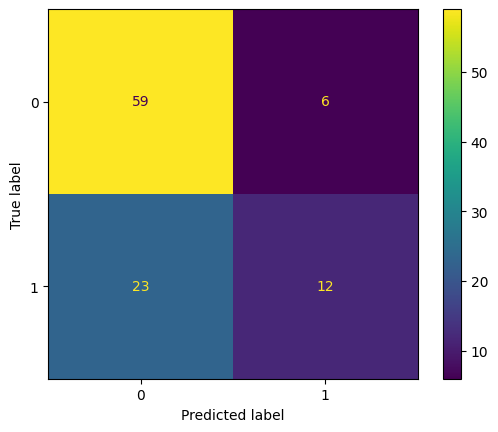

In [136]:
# Run the following

y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question**: Conclude: did removing columns decrease the information on Risk contained by the dataset? Was this an expected behaviour?

**Answer**: The results show that the accuracy remains at 0.71, even after restricting the variables used to the Markov Blanket variables. The variables selected therefore contain all the information needed to predict the risk. The Markov Blanket represents the minimum set of variables which, once known, make the target variable independent of the others. This behaviour was therefore expected, as the Markov Blanket is designed to include all relevant information about the target variable.


**Question**: Did removing column increase accuracy? Suggest an explanation why.

**Answer**: No, it remained at 0.71. This indicates that the variables outside the markov blanket did not provide any additional information useful for predicting Risk, so the variables eliminated were redundant or irrelevant.

**Question**: Conclude on the predictive performance of bayesian modeling versus XGBoost for this dataset.

**Answer**:

The Bayesian model (markov blanket) is useful for understanding the dependencies between variables and can guide the selection of characteristics in a theoretical way whereas XGBoost is a more flexible model, especially effective on large datasets with complex relationships between variables. In our case XGBoost has not been shown superior thtat the Bayesian Model.